In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

In [2]:
file_path = "credit-worthiness-prediction/train.csv"

data = pd.read_csv(file_path)

data.head()

,ID,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,74768,LP002231,1,1,0,1,0,8328,0.000000,17,363,1,2,1,6000
1,79428,LP001448,1,1,0,0,0,150,3857.458782,188,370,1,1,0,6000
2,70497,LP002231,0,0,0,0,0,4989,314.472511,17,348,1,0,0,6000
3,87480,LP001385,1,1,0,0,0,150,0.000000,232,359,1,1,1,3750
4,33964,LP002231,1,1,1,0,0,8059,0.000000,17,372,1,0,1,3750


In [3]:
data['Total_Income'] = data['ApplicantIncome'] + data['CoapplicantIncome']

In [4]:
data['Loan_Income_Ratio'] = data['LoanAmount'] / data['Total_Income']

In [5]:
data['Dependents'] = data['Dependents'].replace('3+', 3).astype(int)
data['Income_Per_Dependent'] = data['Total_Income'] / (data['Dependents'] + 1)

In [6]:
# Apply log transformation
data['ApplicantIncome_Log'] = np.log1p(data['ApplicantIncome'])
data['LoanAmount_Log'] = np.log1p(data['LoanAmount'])

In [7]:
print(data['Total_Income'].describe())

count     5898.000000
mean      9027.981506
std       9479.564621
min        150.000000
25%       3730.000000
50%       7796.748153
75%      11028.641894
max      86414.875663
Name: Total_Income, dtype: float64


In [8]:
bins = [0, 3730, 7797, 11029, 15000, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High', 'Top']
data['Income_Bin'] = pd.cut(data['Total_Income'], bins=bins, labels=labels)

In [9]:
data.head()

,ID,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Loan_Income_Ratio,Income_Per_Dependent,ApplicantIncome_Log,LoanAmount_Log,Income_Bin
0,74768,LP002231,1,1,0,1,0,8328,0.000000,17,363,1,2,1,8328.000000,0.002041,8328.000000,9.027499,2.890372,High
1,79428,LP001448,1,1,0,0,0,150,3857.458782,188,370,1,1,0,4007.458782,0.046913,4007.458782,5.017280,5.241747,Medium
2,70497,LP002231,0,0,0,0,0,4989,314.472511,17,348,1,0,0,5303.472511,0.003205,5303.472511,8.515191,2.890372,Medium
3,87480,LP001385,1,1,0,0,0,150,0.000000,232,359,1,1,1,150.000000,1.546667,150.000000,5.017280,5.451038,Low
4,33964,LP002231,1,1,1,0,0,8059,0.000000,17,372,1,0,1,8059.000000,0.002109,4029.500000,8.994669,2.890372,High


In [10]:
data = data.drop(['Loan_ID', 'ID'], axis=1)


In [11]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Loan_Income_Ratio,Income_Per_Dependent,ApplicantIncome_Log,LoanAmount_Log,Income_Bin
0,1,1,0,1,0,8328,0.000000,17,363,1,2,1,8328.000000,0.002041,8328.000000,9.027499,2.890372,High
1,1,1,0,0,0,150,3857.458782,188,370,1,1,0,4007.458782,0.046913,4007.458782,5.017280,5.241747,Medium
2,0,0,0,0,0,4989,314.472511,17,348,1,0,0,5303.472511,0.003205,5303.472511,8.515191,2.890372,Medium
3,1,1,0,0,0,150,0.000000,232,359,1,1,1,150.000000,1.546667,150.000000,5.017280,5.451038,Low
4,1,1,1,0,0,8059,0.000000,17,372,1,0,1,8059.000000,0.002109,4029.500000,8.994669,2.890372,High


In [16]:
income_bin_encoded = pd.get_dummies(data['Income_Bin'], prefix='Income_Bin')

data = pd.concat([data, income_bin_encoded], axis=1)

data.drop('Income_Bin', axis=1, inplace=True)

In [17]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5898 entries, 0 to 5897
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                5898 non-null   int64  
 1   Married               5898 non-null   int64  
 2   Dependents            5898 non-null   int32  
 3   Education             5898 non-null   int64  
 4   Self_Employed         5898 non-null   int64  
 5   ApplicantIncome       5898 non-null   int64  
 6   CoapplicantIncome     5898 non-null   float64
 7   LoanAmount            5898 non-null   int64  
 8   Loan_Amount_Term      5898 non-null   int64  
 9   Credit_History        5898 non-null   int64  
 10  Property_Area         5898 non-null   int64  
 11  Loan_Status           5898 non-null   int64  
 12  Total_Income          5898 non-null   float64
 13  Loan_Income_Ratio     5898 non-null   float64
 14  Income_Per_Dependent  5898 non-null   float64
 15  ApplicantIncome_Log  

Gender                  0
Married                 0
Dependents              0
Education               0
Self_Employed           0
ApplicantIncome         0
CoapplicantIncome       0
LoanAmount              0
Loan_Amount_Term        0
Credit_History          0
Property_Area           0
Loan_Status             0
Total_Income            0
Loan_Income_Ratio       0
Income_Per_Dependent    0
ApplicantIncome_Log     0
LoanAmount_Log          0
Income_Bin_Low          0
Income_Bin_Medium       0
Income_Bin_High         0
Income_Bin_Very High    0
Income_Bin_Top          0
dtype: int64

In [37]:
X = data[['Loan_Amount_Term','ApplicantIncome_Log','Income_Per_Dependent', 
          'Total_Income', 'Loan_Income_Ratio', 'LoanAmount_Log', 'Property_Area', 'Dependents', 'Education', 'Credit_History']]
y = data['Loan_Status']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [39]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Accuracy: 0.8056497175141243

Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.02      0.03       296
           1       0.83      0.96      0.89      1474

    accuracy                           0.81      1770
   macro avg       0.47      0.49      0.46      1770
weighted avg       0.71      0.81      0.75      1770



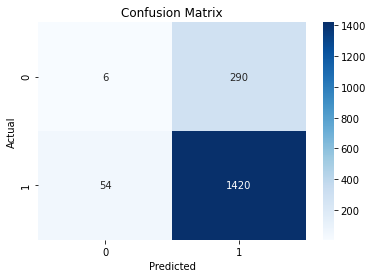

In [40]:
y_pred = xgb_model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

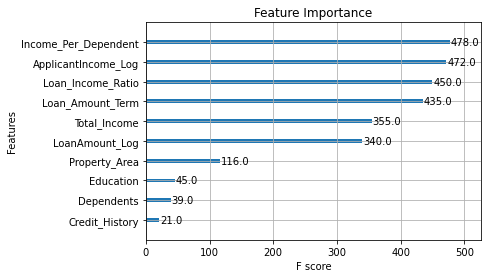

In [41]:
xgb.plot_importance(xgb_model, max_num_features=20)
plt.title("Feature Importance")
plt.show()

In [42]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss'),
                           param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


In [43]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))

Tuned Model Accuracy: 0.8327683615819209
